## Fitting radial velocity of stars without spectral models.

> Import packages.

In [1]:
# import package
import seaborn.apionly as sns

%matplotlib inline

# import packages
import numpy as np
from scipy.optimize import curve_fit

from scipy import interpolate
from sklearn import linear_model
from multiprocessing import Pool
from random import shuffle
import os

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cm
from matplotlib import gridspec

from astropy.io import fits

from cycler import cycler


/Users/yting/anaconda3/lib/python3.7/site-packages/matplotlib/__init__.py:855: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))
/Users/yting/anaconda3/lib/python3.7/site-packages/matplotlib/__init__.py:846: MatplotlibDeprecationWarning: 
The text.latex.unicode rcparam was deprecated in Matplotlib 2.2 and will be removed in 3.1.
  "2.2", name=key, obj_type="rcparam", addendum=addendum)
/Users/yting/anaconda3/lib/python3.7/site-packages/seaborn/apionly.py:9: UserWarning: As seaborn no longer sets a default style on import, the seaborn.apionly module is deprecated. It will be removed in a future version.
  warnings.warn(msg, UserWarning)


In [2]:
# define plot properties
import matplotlib.cm as cm

from matplotlib import rcParams
from matplotlib import rc
from mpl_toolkits.axes_grid1 import make_axes_locatable

def rgb(r,g,b):
    return (float(r)/256.,float(g)/256.,float(b)/256.)

cb2 = [rgb(31,120,180), rgb(255,127,0), rgb(51,160,44), rgb(227,26,28), \
       rgb(10,10,10), rgb(253,191,111), rgb(178,223,138), rgb(251,154,153)]

rcParams['figure.figsize'] = (11,7.5)
rcParams['figure.dpi'] = 300

rcParams['lines.linewidth'] = 1

rcParams['axes.prop_cycle'] = cycler('color', cb2)
rcParams['axes.facecolor'] = 'white'
rcParams['axes.grid'] = False

rcParams['patch.facecolor'] = cb2[0]
rcParams['patch.edgecolor'] = 'white'

rcParams['font.family'] = 'Bitstream Vera Sans' 
rcParams['font.size'] = 25
rcParams['font.weight'] = 300


> How to fit a line with pytorch.

/Users/yting/anaconda3/lib/python3.7/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['Bitstream Vera Sans'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


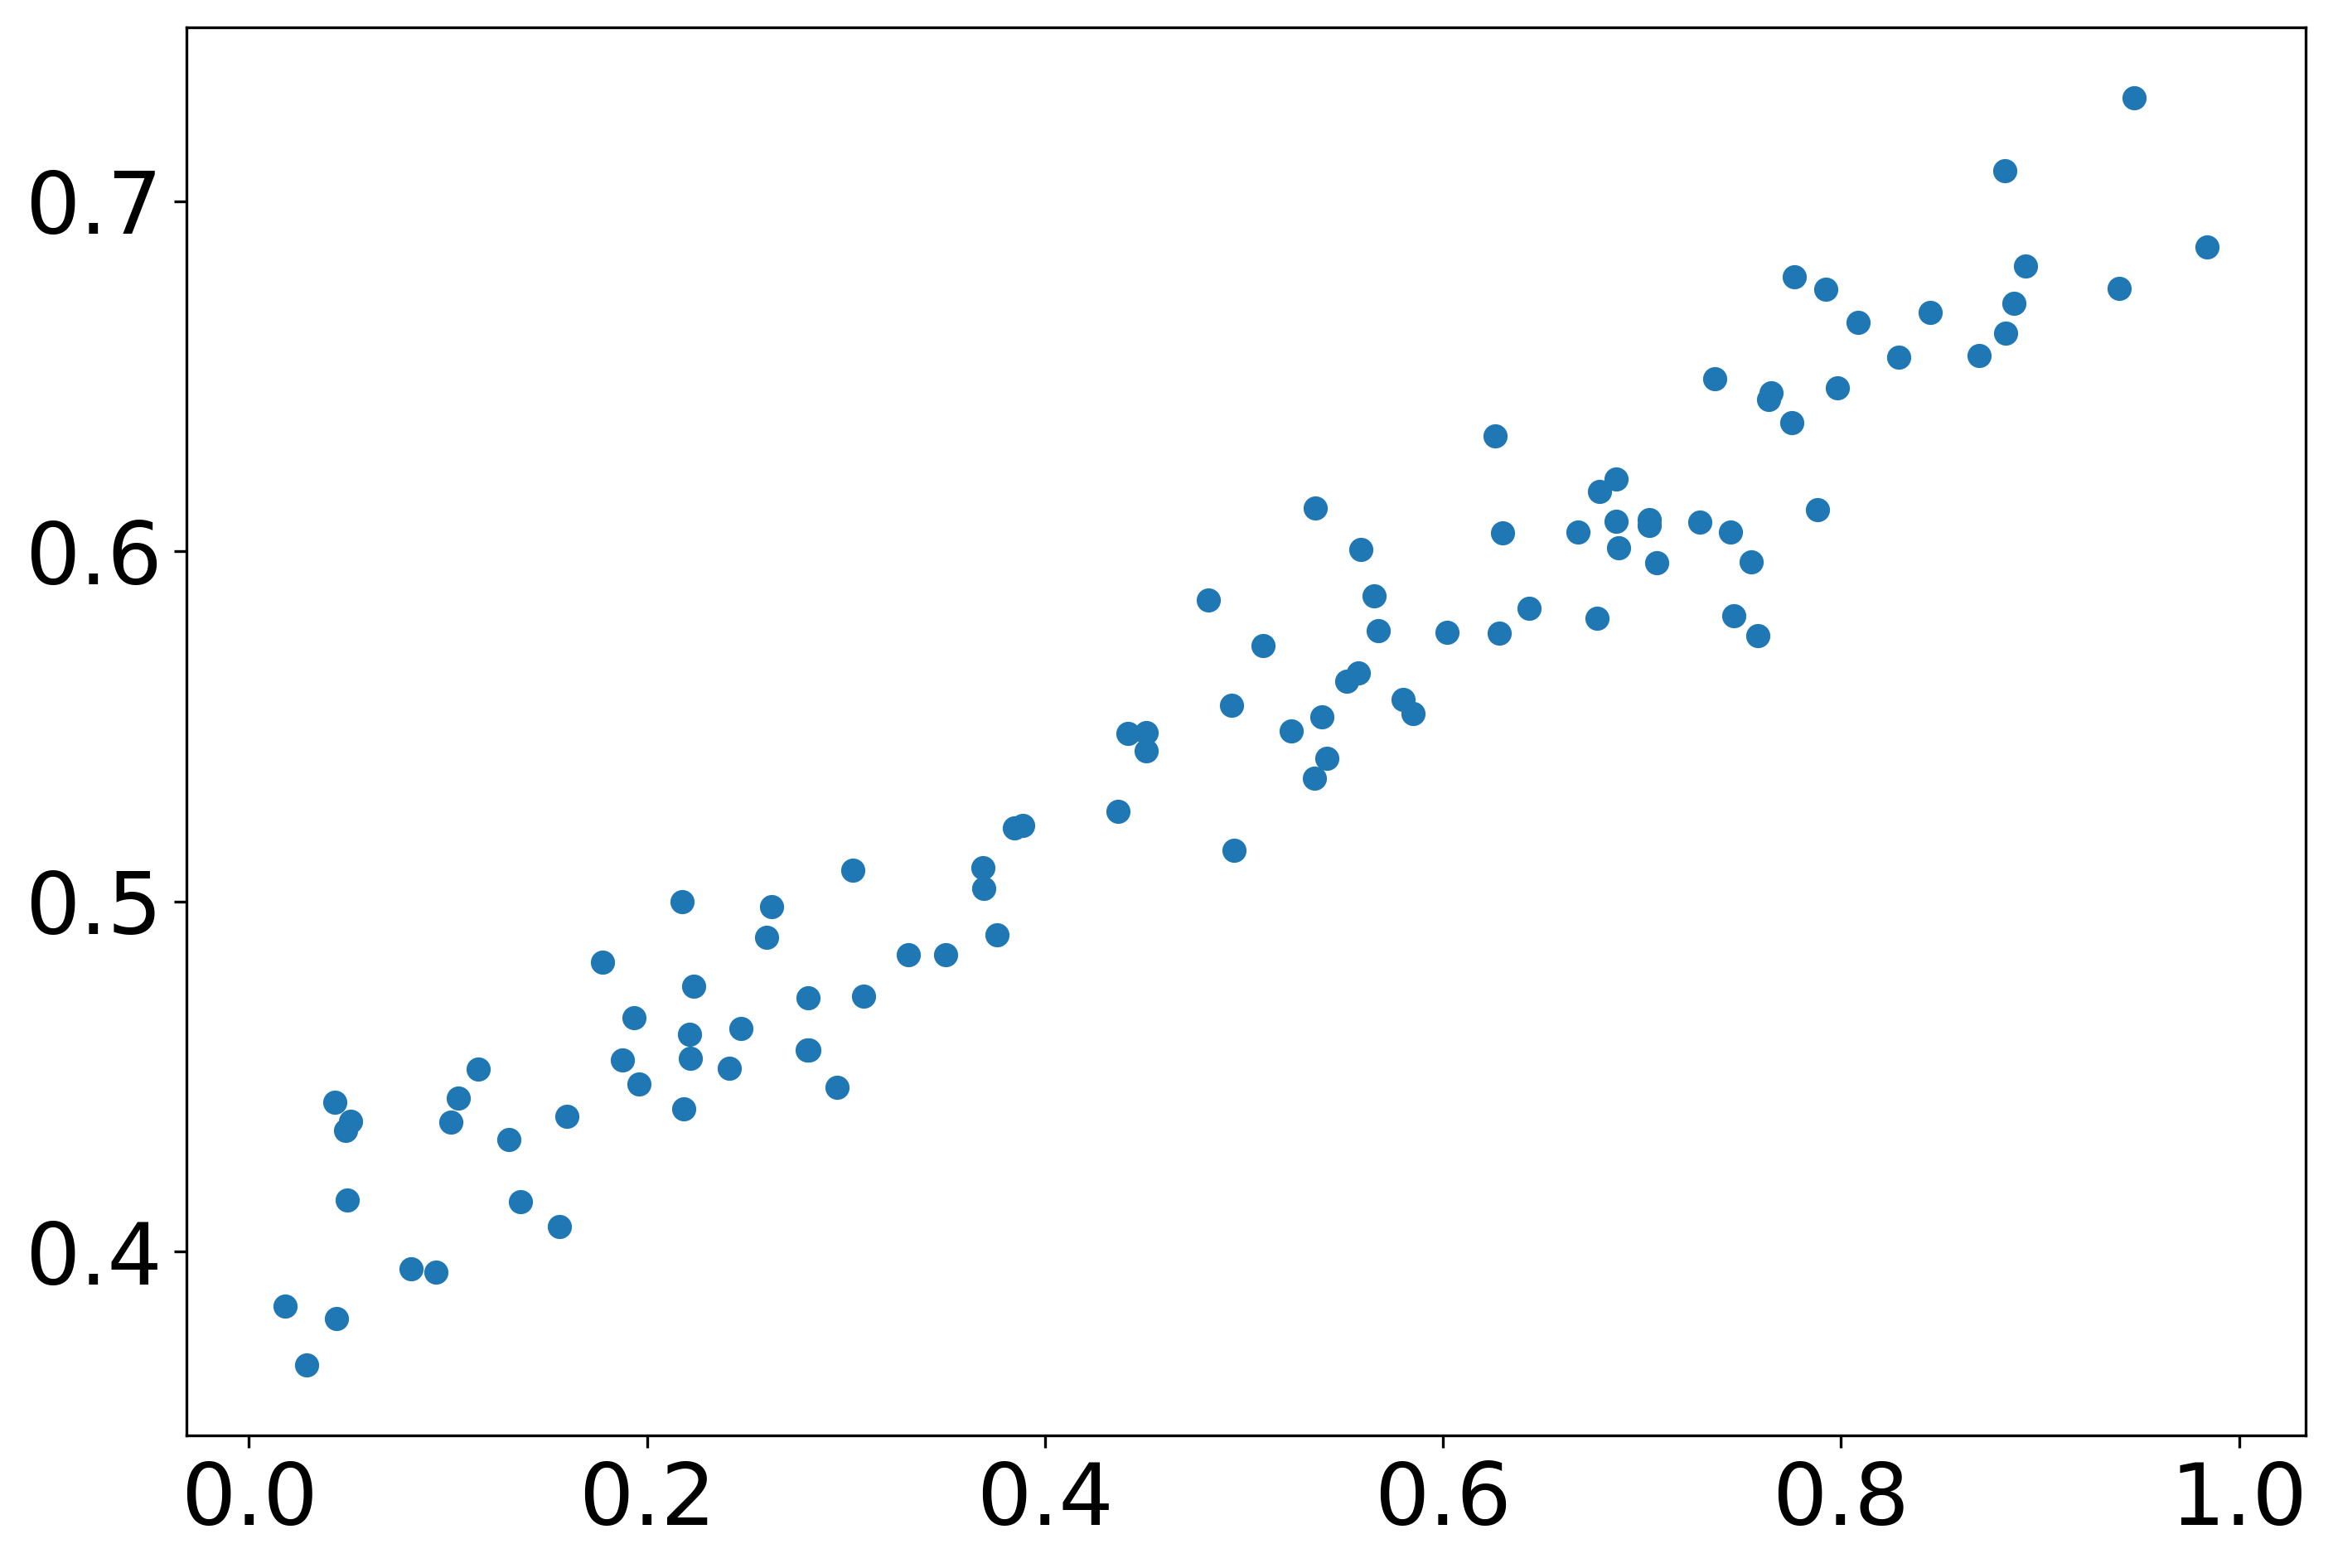

In [3]:
# make a linear line with noise in y
x = np.random.uniform(size=100)
y = 0.3*x + 0.4 + np.random.normal(size=x.size)*0.02

plt.scatter(x,y)

In [4]:
# import packages
import numpy as np
import sys
import os
import torch
from torch.autograd import Variable


#========================================================================================================
# define function to optimize
class linear_func(torch.nn.Module):
    def __init__(self):
        super(linear_func, self).__init__()
        self.a = torch.nn.Parameter(torch.randn(1))
        self.b = torch.nn.Parameter(torch.randn(1))

    def forward(self, x):
        y_pred = self.a*x + self.b
        return y_pred
    
model = linear_func()

# check that the parameters are indeed registered
for param in model.parameters():
    print(param.data)
    
#========================================================================================================
### run on GPU ###
#dtype = torch.cuda.FloatTensor
#torch.set_default_tensor_type('torch.cuda.FloatTensor')

### run on CPU ###
dtype = torch.FloatTensor
torch.set_default_tensor_type('torch.FloatTensor')
   
#---------------------------------------------------------------------------------------------------------
# assume L2 loss
loss_fn = torch.nn.MSELoss()
    
# make pytorch variables
x = Variable(torch.from_numpy(x)).type(dtype)
y = Variable(torch.from_numpy(y), requires_grad=False).type(dtype)
 
# optimizer
learning_rate = 0.01
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

#---------------------------------------------------------------------------------------------------------
# initiate training
loss_data = 10**8
training_loss = []

# optimize
for i in range(10**4):
    if i % 10**3 == 0:
        print('Step ' + str(i) \
                  + ': Training set loss = ' + str(int(loss_data*1e5)/1e5))
        
    y_pred = model(x)
    loss = loss_fn(y_pred, y)

#---------------------------------------------------------------------------------------------------------
    # back propagation
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # record training loss
    loss_data = loss.data.item()
    training_loss.append(loss_data)
            

tensor([-1.2970])
tensor([1.2335])
Step 0: Training set loss = 100000000.0
Step 1000: Training set loss = 0.00047
Step 2000: Training set loss = 0.00047
Step 3000: Training set loss = 0.00047
Step 4000: Training set loss = 0.00047
Step 5000: Training set loss = 0.00047
Step 6000: Training set loss = 0.00047
Step 7000: Training set loss = 0.00047
Step 8000: Training set loss = 0.00047
Step 9000: Training set loss = 0.00047


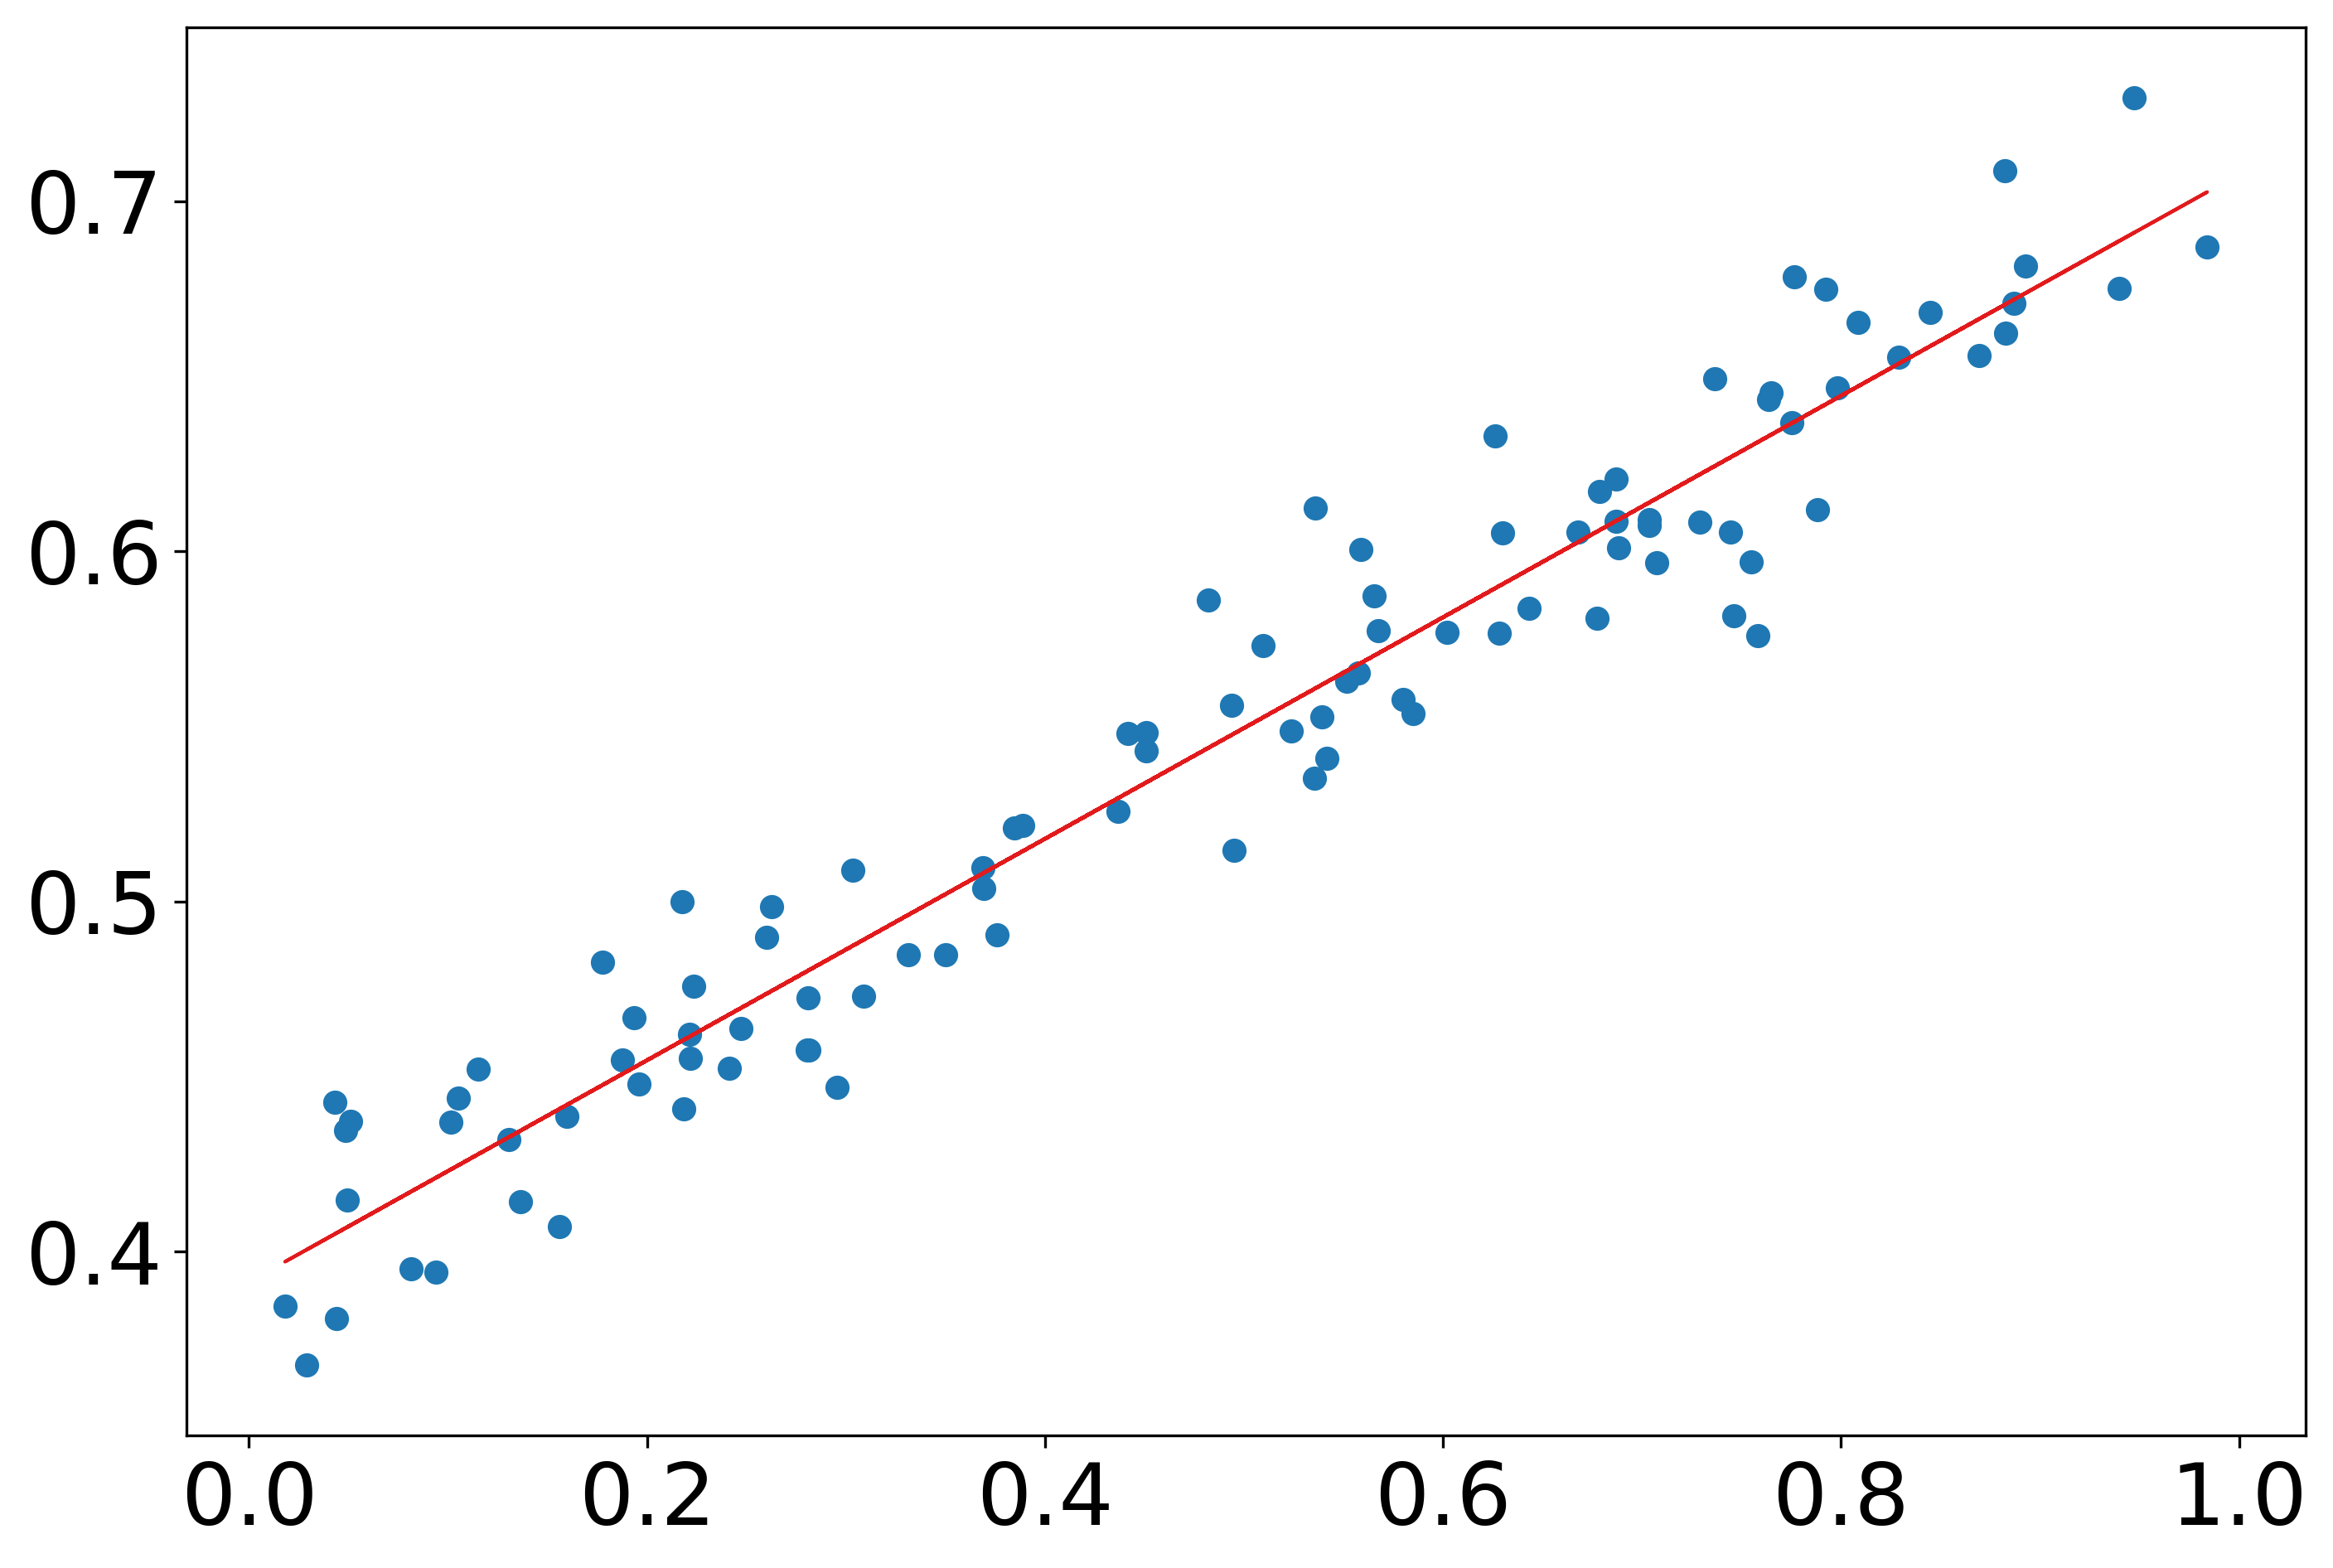

In [5]:
plt.scatter(x, y)
plt.plot(x.data.numpy(), y_pred.data.numpy(), color=cb2[3])

> Making mocks (require YST's binspec).

https://github.com/tingyuansen/binspec_plus

In [6]:
# import bin spec packages
from binspec import utils
from binspec import spectral_model
from binspec import fitting
from binspec.spectral_model import get_unnormalized_spectrum_single_star,\
get_normalized_spectrum_single_star, get_Teff2_logg2_NN
  
# read in the standard wavelength grid onto which we interpolate spectra.
wavelength = utils.load_wavelength_array()
num_pixel = wavelength.size

# define pixels for continuum normalization
cont_pixels = utils.load_cannon_contpixels()

# read in all individual neural networks we'll need. 
NN_coeffs_norm = utils.read_in_neural_network(name = 'normalized_spectra')
NN_coeffs_flux = utils.read_in_neural_network(name = 'unnormalized_spectra')
NN_coeffs_R = utils.read_in_neural_network(name = 'radius')
NN_coeffs_Teff2_logg2 = utils.read_in_neural_network(name = 'Teff2_logg2')


> Make a binary spectrum

(0.6, 1.2)

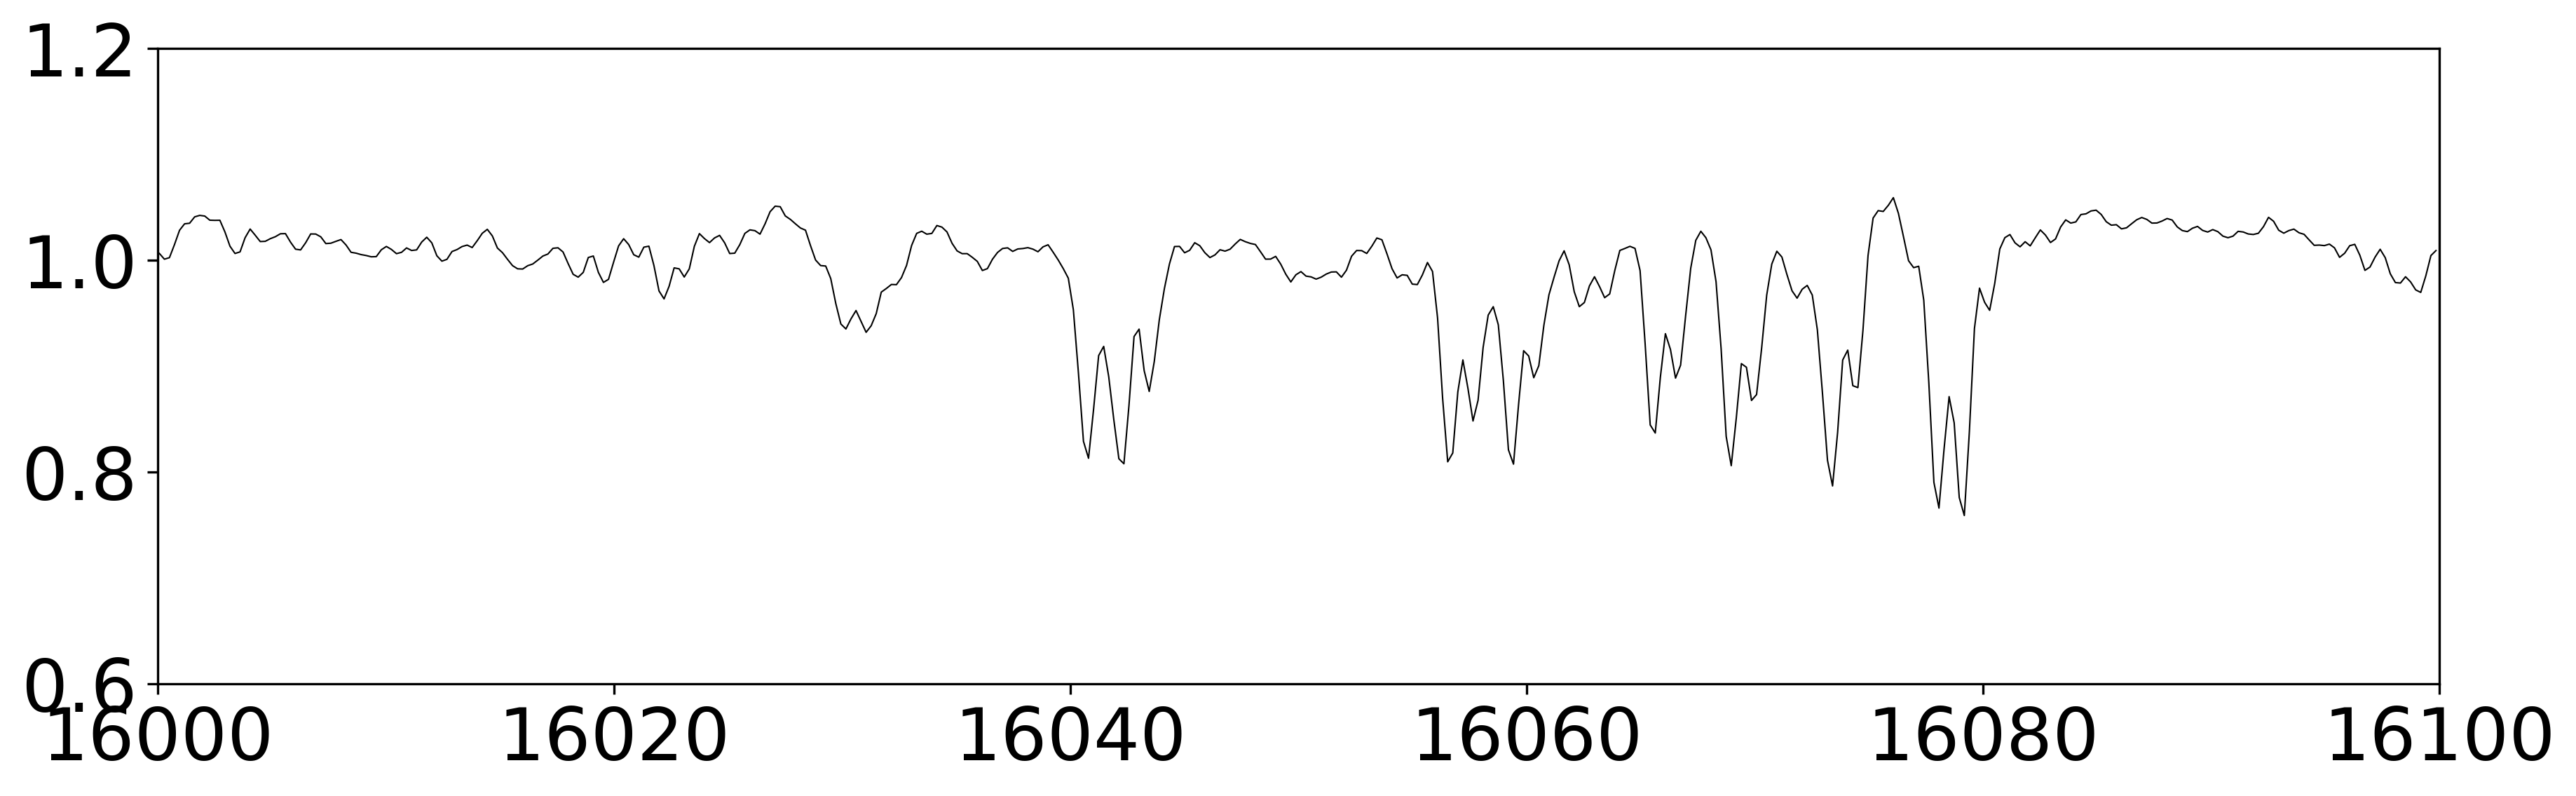

In [7]:
# predict a binary spec
Teff1 = 3447
logg1 = 4.9
feh = 0
alphafe = 0
mass_ratio = 0.8
vmacro1 = 2.
vmacro2 = 5.
vlos1 = -10.
vlos2 = 10.
spec_err = 1e-2*np.ones(len(wavelength))

#--------------------------------------------------------------------------------------------------
# the teff and logg of the secondary given the mass ratio
Teff2, logg2 = get_Teff2_logg2_NN(labels = [Teff1, logg1, feh, mass_ratio], 
                                  NN_coeffs_Teff2_logg2 = NN_coeffs_Teff2_logg2)

# define the labels
labels1 = [Teff1, logg1, feh, alphafe, vmacro1, vlos1]
labels2 = [Teff2, logg2, feh, alphafe, vmacro2, vlos2]
  
#--------------------------------------------------------------------------------------------------
# extract flux spectra
f_lambda1 = get_unnormalized_spectrum_single_star(labels = labels1, 
        NN_coeffs_norm = NN_coeffs_norm, NN_coeffs_flux = NN_coeffs_flux, 
        NN_coeffs_R = NN_coeffs_R)
f_lambda2 = get_unnormalized_spectrum_single_star(labels = labels2, 
        NN_coeffs_norm = NN_coeffs_norm, NN_coeffs_flux = NN_coeffs_flux, 
        NN_coeffs_R = NN_coeffs_R)

#--------------------------------------------------------------------------------------------------
# add together
f_lambda_binary = f_lambda1 + f_lambda2

# continuum normalization
cont = utils.get_apogee_continuum(wavelength = wavelength, spec = f_lambda_binary, 
        spec_err = spec_err, cont_pixels = cont_pixels)
real_bin_spec = f_lambda_binary/cont
    

#==================================================================================================
# plot the spectrum
lambda_min, lambda_max = 16000, 16100# for plotting 
plt.figure(figsize=(14, 4))
m = (wavelength < lambda_max) & (wavelength > lambda_min)
plt.plot(wavelength[m], real_bin_spec[m], 'k', lw=0.5)
plt.xlim(lambda_min, lambda_max)
plt.ylim(0.6, 1.2)


> Let's just start with a single stars with random RV shift.

(30, 7214)


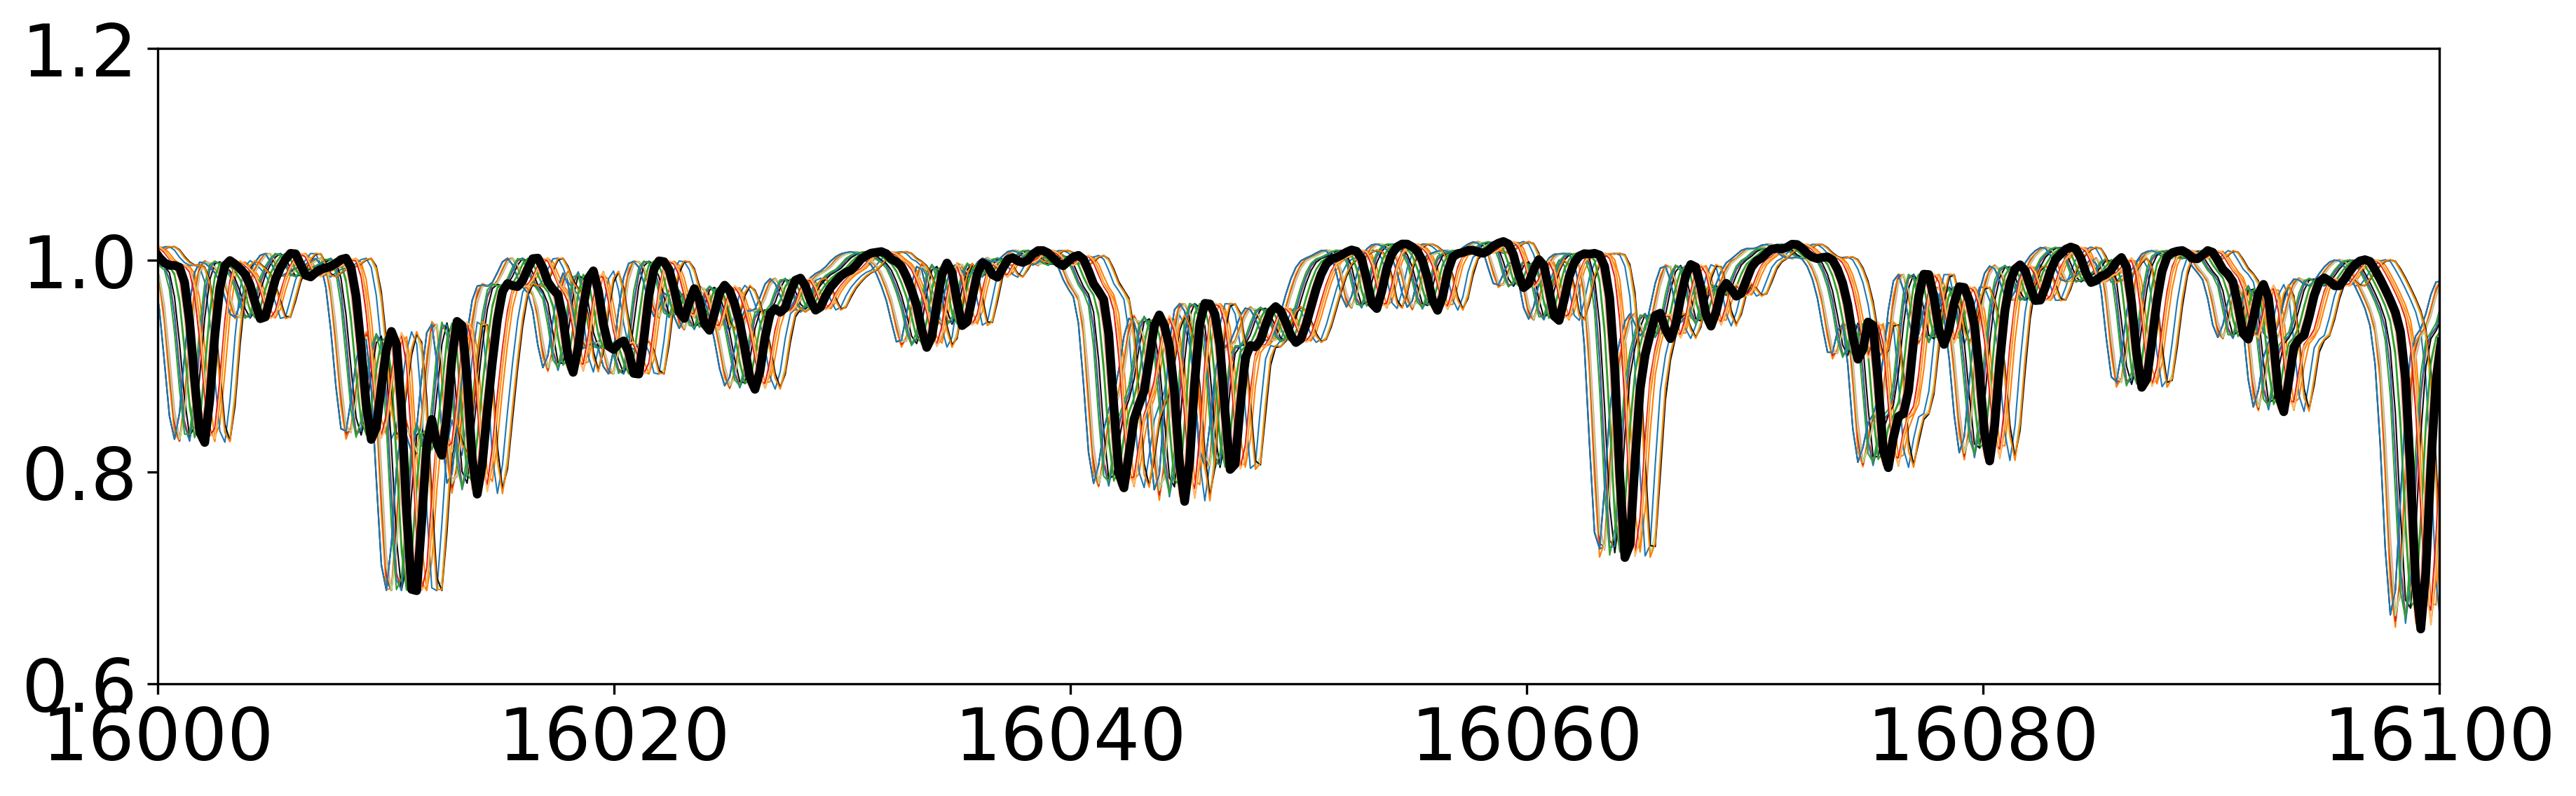

In [41]:
# consider a red clump stars
Teff1 = 4750.
logg1 = 2.5
feh = 0.
alphafe = 0.
vmacro = 2.

# make RV curve
num_obs = 30
RV_array = np.random.uniform(size=num_obs)*50. -25.

# just for normalization, we assume noiseless first
spec_err = 1e-2*np.ones(len(wavelength))
  
#--------------------------------------------------------------------------------------------------
# extract flux spectra
spec_array = []

# make n_obs of mock observations
for i in range(RV_array.size):
    labels1 = [Teff1, logg1, feh, alphafe, vmacro, 0] 
    spec_array.append(get_normalized_spectrum_single_star(labels = labels1, 
            NN_coeffs_norm = NN_coeffs_norm, NN_coeffs_flux = NN_coeffs_flux))
spec_array = np.array(spec_array)
print(spec_array.shape)

#--------------------------------------------------------------------------------------------------
# radial velocity shift
# code up interp1d ourselves -- will come in handy to translate this to pytrorch, since 
# pytroch deos not have interp1d
c = 3e5
spec_shifted = []
for i in range(RV_array.size):
    doppler_factor = np.sqrt((1 - RV_array[i]/c)/(1 + RV_array[i]/c))  
    new_wavelength = wavelength*doppler_factor
    ind = np.searchsorted(wavelength[:-1], new_wavelength) - 1
    slopes = (spec_array[i,1:] - spec_array[i,:-1])/(wavelength[1:]-wavelength[:-1])
    spec_shifted.append(spec_array[i,ind] + slopes[ind]*(new_wavelength - wavelength[ind])) 
spec_shifted = np.array(spec_shifted)


#==================================================================================================
# plot the spectrum
lambda_min, lambda_max = 16000, 16100# for plotting 
plt.figure(figsize=(14, 4))
plt.plot(wavelength, spec_shifted.T, lw=0.5)
plt.xlim(lambda_min, lambda_max)
plt.plot(wavelength, spec_array[0,:], color="black", lw=3) ## rest frame spectrum
plt.ylim(0.6, 1.2)

#==================================================================================================
# save array
np.savez("fitting_spectra.npz",\
         spec_shifted = spec_shifted[:,10:-10],\
         RV_array = RV_array,\
         spectra_rest = spec_array[0,10:-10],\
         wavelength = wavelength[10:-10])


(array([9.70000e+01, 3.07000e+02, 4.48000e+02, 9.71000e+02, 2.84500e+03,
        6.58900e+03, 1.38160e+04, 3.37840e+04, 1.01201e+05, 5.57620e+04]),
 array([0.50222836, 0.55723404, 0.61223971, 0.66724539, 0.72225106,
        0.77725673, 0.83226241, 0.88726808, 0.94227376, 0.99727943,
        1.05228511]),
 <a list of 10 Patch objects>)

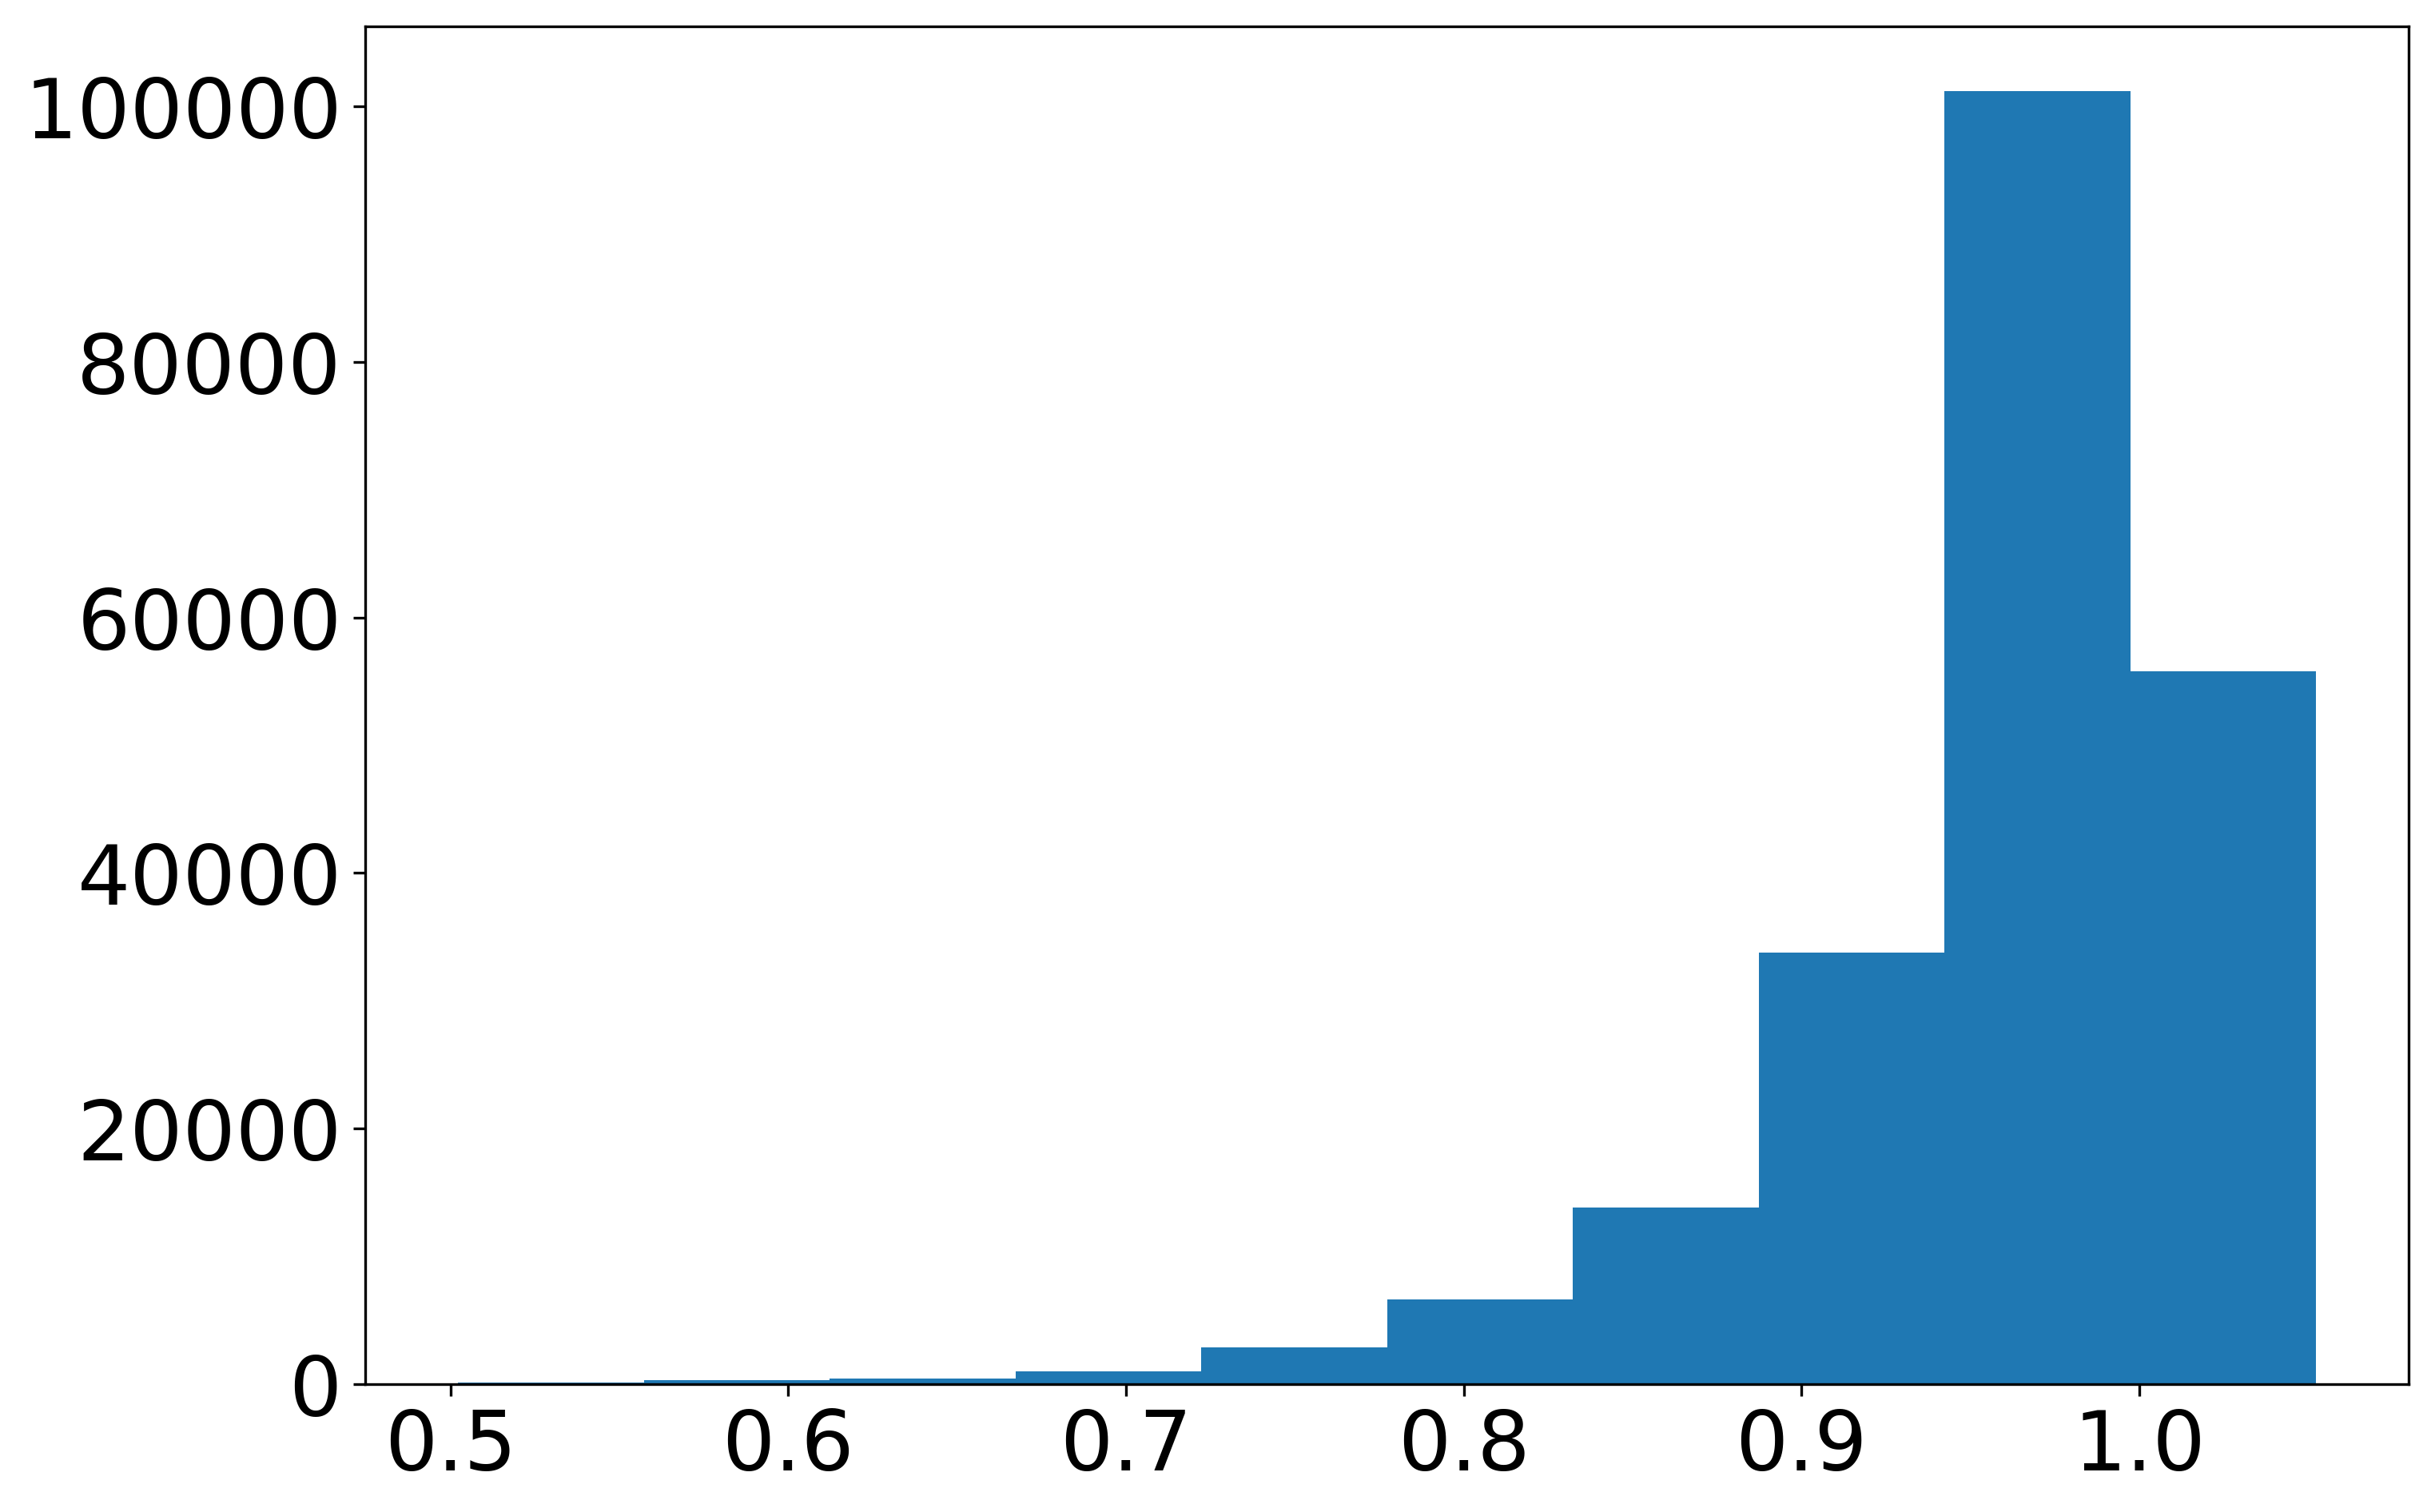

In [40]:
plt.hist(spec_shifted[:,10:-10].ravel())

## After running with wobble.py

> Plot spectrum results.

In [42]:
# restore training set
temp = np.load("fitting_spectra.npz")
spec_shifted = temp["spec_shifted"]
RV_array = temp["RV_array"]
spectra_rest = temp["spectra_rest"]
wavelength = temp["wavelength"]

# restore results
temp = np.load("../results.npz")
spec_shifted_recovered = temp["spec_shifted_recovered"]
rest_spec_recovered = temp["rest_spec_recovered"]
rv_recovered = temp["rv_recovered"]

(0, 200)

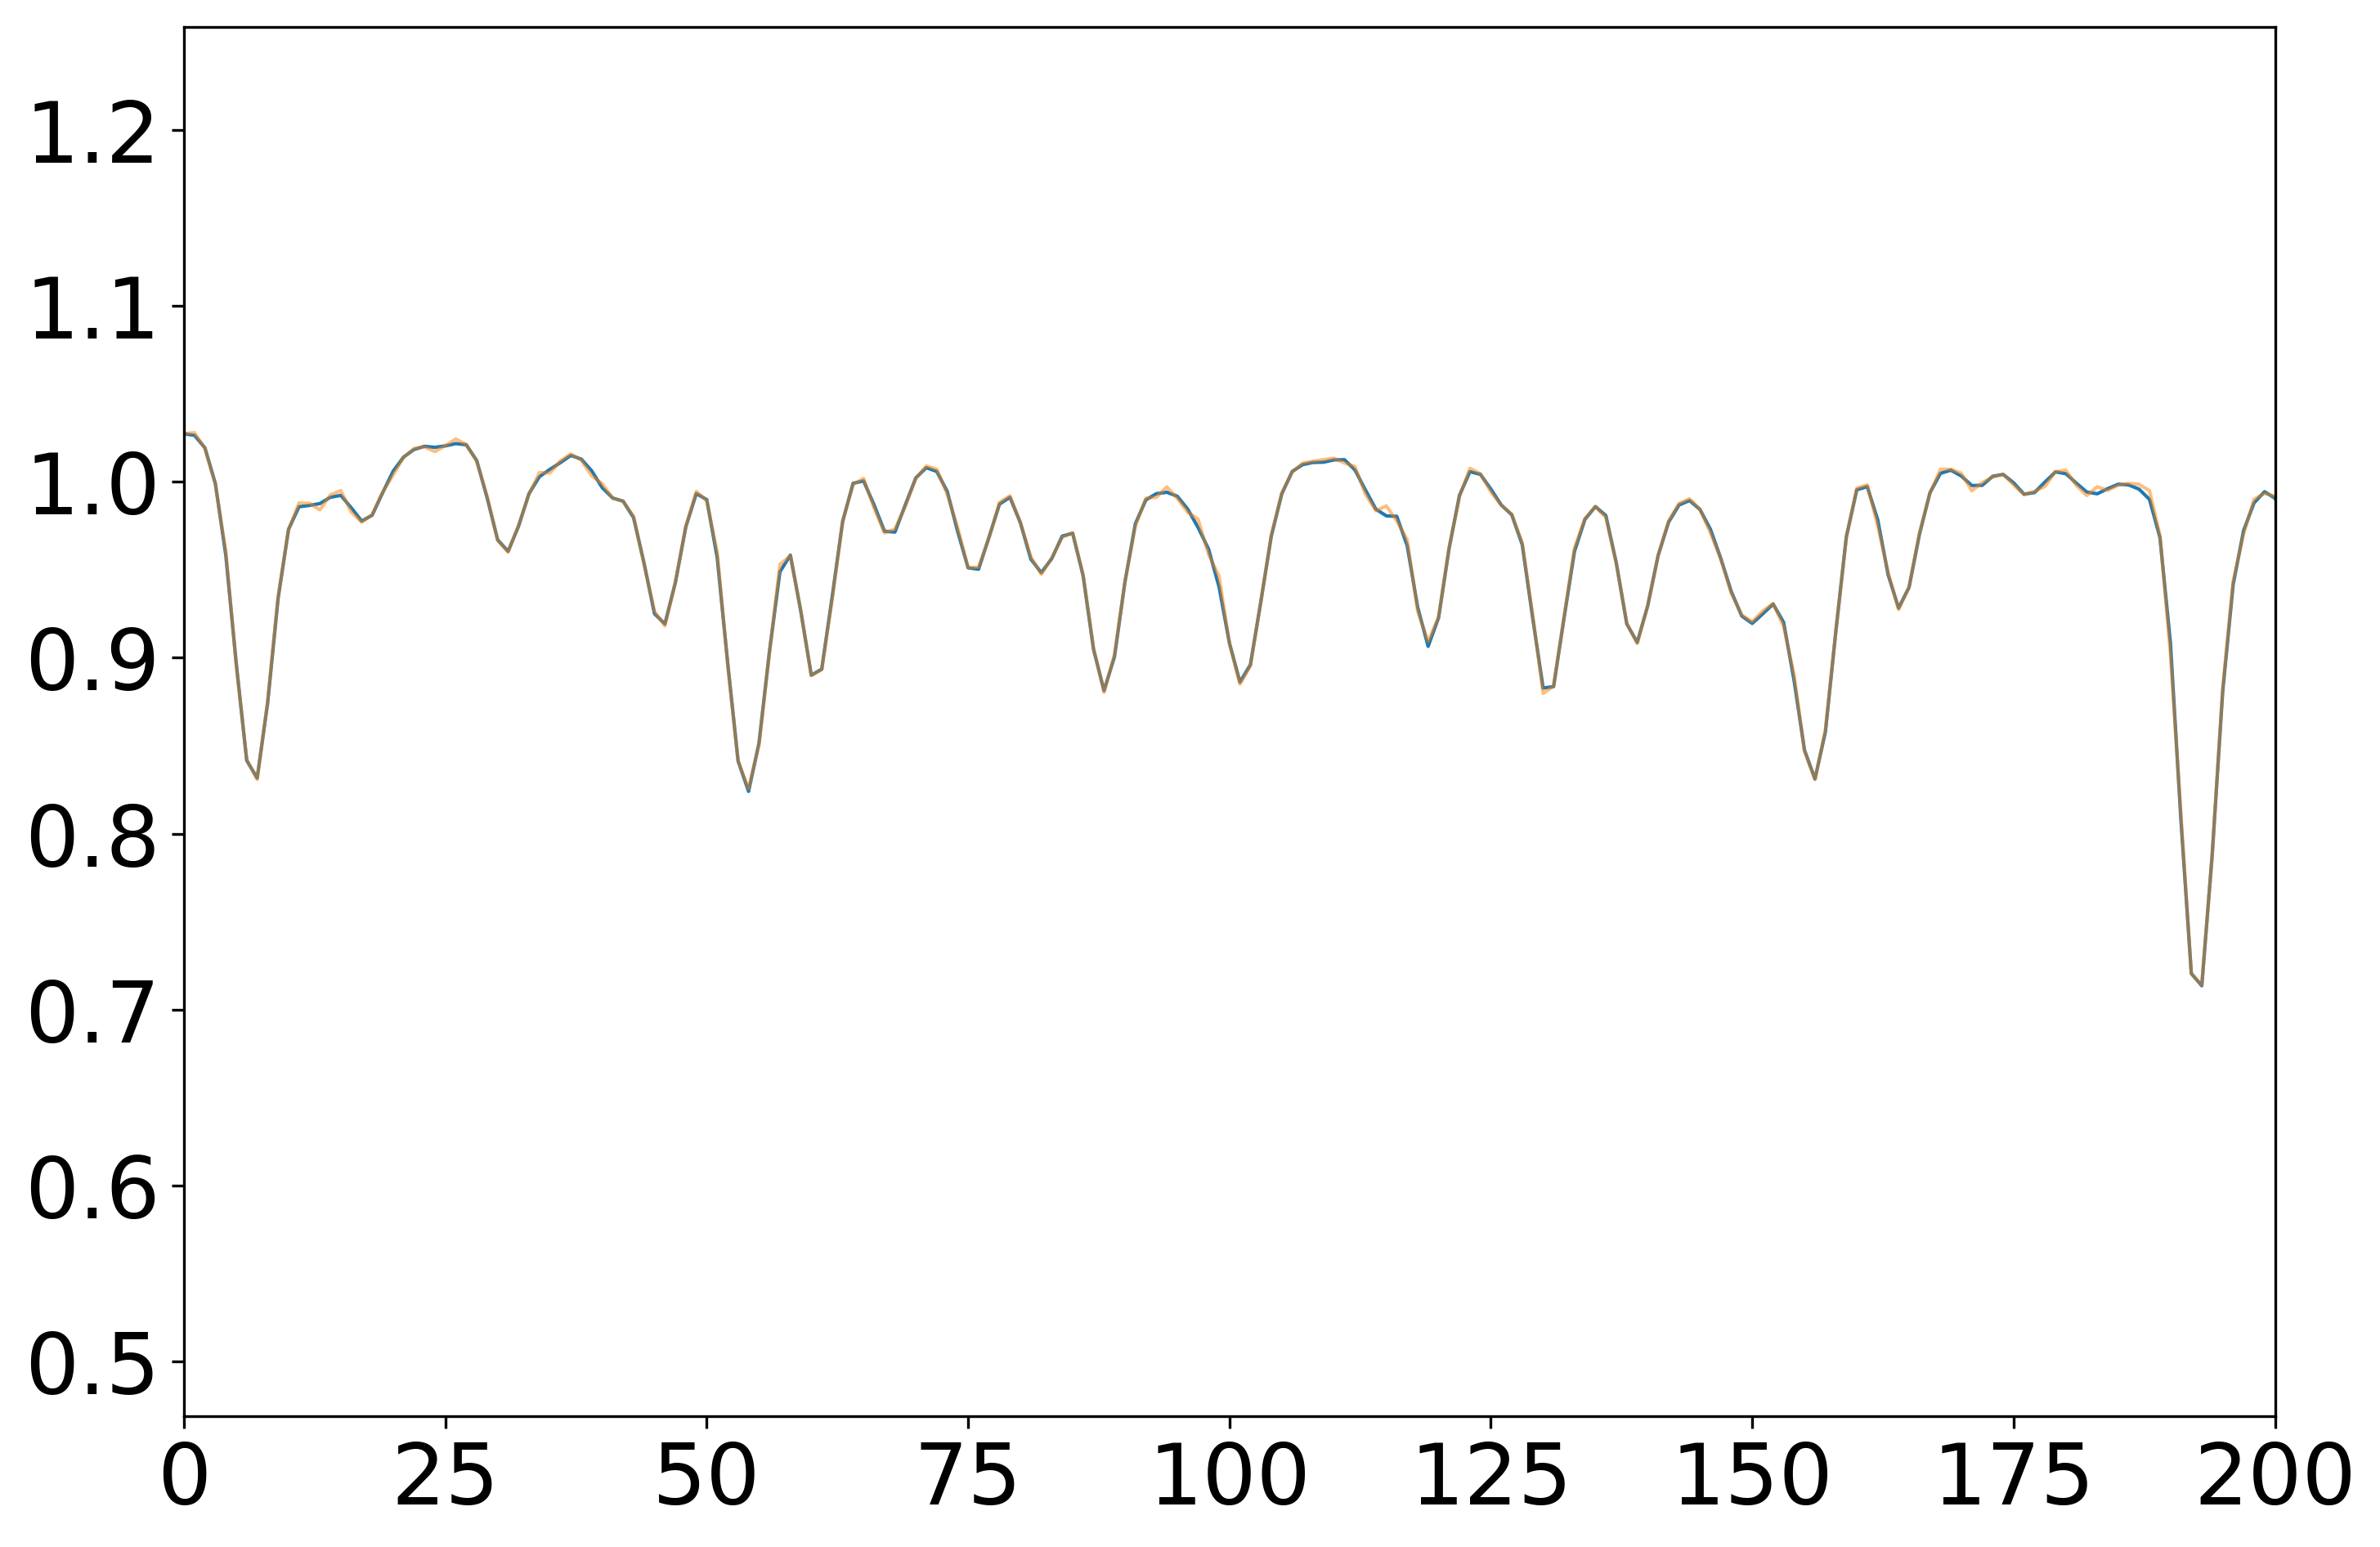

In [47]:
plt.plot(spec_shifted[0,:])
plt.plot(spec_shifted_recovered[0,:], alpha=0.5)
plt.xlim([0,200])

> RV prediction.

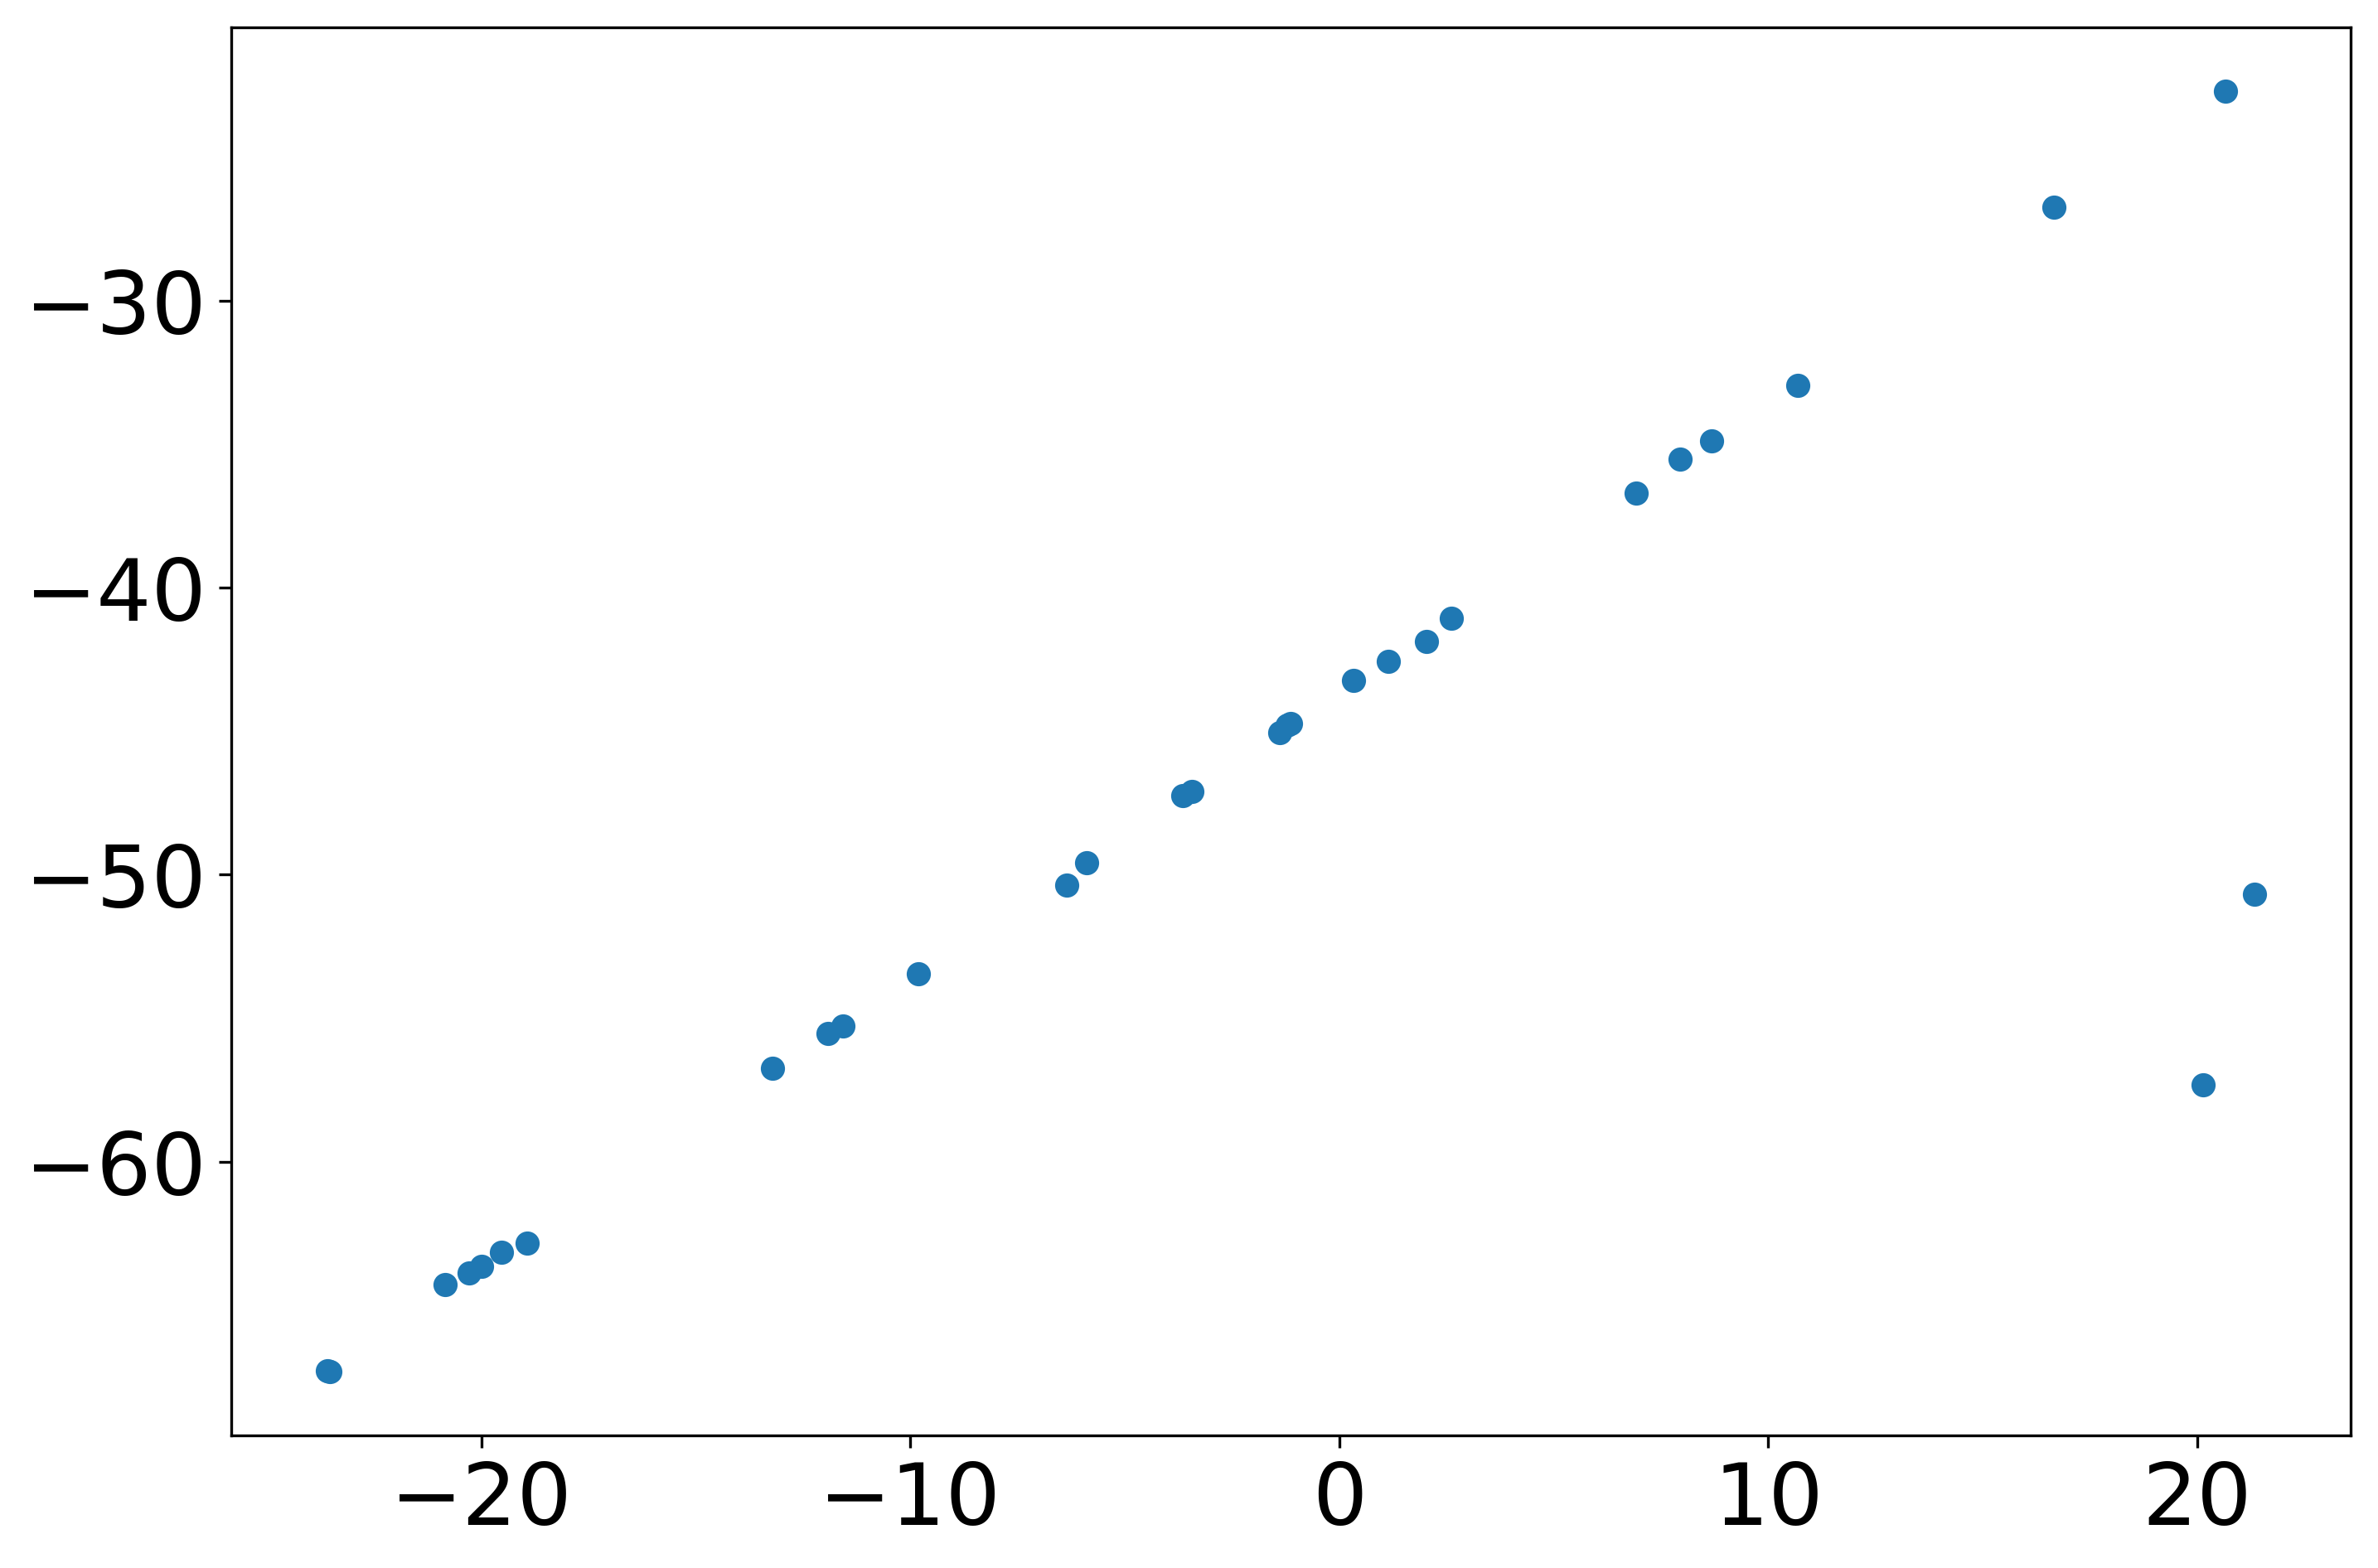

In [48]:
plt.scatter(RV_array,rv_recovered)
